In [1]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
import torch
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.special import softmax
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer




e:\Anaconda\envs\cuda_test\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
e:\Anaconda\envs\cuda_test\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
annotateddf = pd.read_csv('popular_comment_Bolt_annotate_Merged.csv')

In [3]:
Bolt_predicted = pd.read_csv('popular_comment_Bolt.csv')

In [4]:
annotateddf['annotator_combined'] = np.where(annotateddf['annotator 1'] == annotateddf['annotator 2'], annotateddf['annotator 1'], np.nan)
valid_count = annotateddf['annotator_combined'].count()
print("valid count: ", valid_count)
annotateddf.dropna(subset=['annotator_combined'], inplace=True)


valid count:  1068


In [5]:
annotateddf['annotator_combined'] = annotateddf['annotator_combined'].astype(str)
sentiment_mapping = {'-1.0': 'negative', '0.0': 'neutral', '1.0': 'positive'}

annotateddf['annotator_combined'] = annotateddf['annotator_combined'].replace(sentiment_mapping)

In [6]:
remove_count_1 = annotateddf['remove 1'].count()
print("remove 1:", remove_count_1)
remove_count_2 = annotateddf['remove 2'].count()
print("remove 2:", remove_count_1)

remove 1: 150
remove 2: 150


In [7]:
count_non_na = annotateddf[['remove 1', 'remove 2']].notna().all(axis=1).sum()
print("common remove: ", count_non_na)

common remove:  34


In [8]:
annotateddf = annotateddf[annotateddf['remove 1'].isna() | annotateddf['remove 2'].isna()]
print(len(annotateddf))

1034


In [9]:
annotation_df = annotateddf[["text","annotator_combined"]]

In [10]:
merged_df = pd.merge(Bolt_predicted, annotation_df, on='text', how='inner')
merged_df.head()

,text,score,neg_score,neu_score,pos_score,label,annotator 1,irony 1,remove 1,annotator 2,irony 2,remove 2,annotator_combined
0,An Ultium based Bolt with NACS and faster char...,219,0.004940,0.088701,0.906359,positive,NaN,NaN,NaN,NaN,NaN,NaN,neutral
1,They had to have something smaller than the Eq...,141,0.378837,0.540830,0.080333,neutral,NaN,NaN,NaN,NaN,NaN,NaN,negative
2,Yes! I just came back to post this very same t...,55,0.003039,0.012690,0.984271,positive,NaN,NaN,NaN,NaN,NaN,NaN,positive
3,Yes!!! So excited! Was thinking I was going to...,52,0.017278,0.055458,0.927264,positive,NaN,NaN,NaN,NaN,NaN,NaN,positive
4,Interesting that they dropped the EV/EUV namep...,21,0.032266,0.881413,0.086321,neutral,NaN,NaN,NaN,NaN,NaN,NaN,neutral


In [11]:
accuracy = accuracy_score(merged_df['annotator_combined'], merged_df['label'])
precision = precision_score(merged_df['annotator_combined'], merged_df['label'], average='weighted')
recall = recall_score(merged_df['annotator_combined'], merged_df['label'], average='weighted')
f1 = f1_score(merged_df['annotator_combined'], merged_df['label'], average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8191489361702128
Precision: 0.8217577552345009
Recall: 0.8191489361702128
F1 Score: 0.8198113471835082


In [12]:
accuracy = accuracy_score(merged_df['annotator_combined'], merged_df['label'])
precision = precision_score(merged_df['annotator_combined'], merged_df['label'], average='micro')
recall = recall_score(merged_df['annotator_combined'], merged_df['label'], average='micro')
f1 = f1_score(merged_df['annotator_combined'], merged_df['label'], average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Accuracy: 0.8191489361702128
Precision: 0.8191489361702128
Recall: 0.8191489361702128
F1 Score: 0.8191489361702128


In [13]:
# Load the tokenizer and model from Hugging Face
model_name = "MarieAngeA13/Sentiment-Analysis-BERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [14]:
text_list = merged_df['text'].tolist()


In [15]:
len(text_list)


1034

In [16]:
# candidate_labels = ['positive', 'neutral', 'negative']
# result = model(text_list, candidate_labels)
import torch
from tqdm import tqdm

all_df = pd.read_csv('cleaned_combined_data.csv')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def sentiment_prediction(df, text_column):
    predictions = []

    for text in tqdm(df[text_column], desc="Predicting Sentiment", total=len(df)):
        # Tokenize and encode the text
        encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)

        # Send encoded inputs to the device
        encoded_input = {key: value.to(device) for key, value in encoded_input.items()}

        # Model inference
        with torch.no_grad():
            output = model(**encoded_input)

        # Move the prediction back to CPU and convert to numpy
        prediction = torch.argmax(output.logits, dim=1).cpu().numpy()[0]
        predictions.append(prediction)

    return predictions

# Assuming you have a DataFrame 'merged_df' and a column 'text' that contains the text
# Add a new column for sentiment predictions
all_df['sentiment_pred_bert'] = sentiment_prediction(all_df, 'text')

# Mapping the predicted indexes to actual sentiment labels
sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}  # Replace with the correct mapping
all_df['sentiment_pred_bert'] = all_df['sentiment_pred_bert'].map(sentiment_labels)

# Now 'merged_df' has a new column 'sentiment_prediction' with the sentiment labels
print(all_df[['text', 'sentiment_pred_bert']])

Predicting Sentiment: 100%|██████████| 49359/49359 [08:47<00:00, 93.59it/s] 


                                                    text sentiment_pred_bert
0      My reward for finally finishing my bachelor’s ...            positive
1                                             100k miles             neutral
2                          Rabbit stowage area on the i3             neutral
3       Picked her up straight from the source in Munich             neutral
4             Picked up this little gem over the weekend             neutral
...                                                  ...                 ...
49354                                         Fake Email             neutral
49355                                               fake             neutral
49356  Looks fake. Why would you have to block Elon’s...            negative
49357  That’s an email sent to execs though. It doesn...             neutral
49358  If it's real I'm fine with it. Email looks lik...            positive

[49359 rows x 2 columns]


In [18]:
all_df = all_df[['text','sentiment_pred_bert']]
all_df

,text,sentiment_pred_bert
0,My reward for finally finishing my bachelor’s ...,positive
1,100k miles,neutral
2,Rabbit stowage area on the i3,neutral
3,Picked her up straight from the source in Munich,neutral
4,Picked up this little gem over the weekend,neutral
...,...,...
49354,Fake Email,neutral
49355,fake,neutral
49356,Looks fake. Why would you have to block Elon’s...,negative
49357,That’s an email sent to execs though. It doesn...,neutral


In [19]:

all_df.to_csv("sentiment_pred_bert_pretrain_and_annotator_all_comments.csv",index=False, encoding='utf-8')
all_df = pd.merge(annotateddf, all_df, on='text', how='inner')
all_df
all_df.to_csv("sentiment_pred_bert_pretrain_and_annotator.csv",index=False, encoding='utf-8')

Accuracy: 0.6334622823984526
Precision: 0.653317965273476
Recall: 0.6334622823984526
F1 Score: 0.6340417897349012


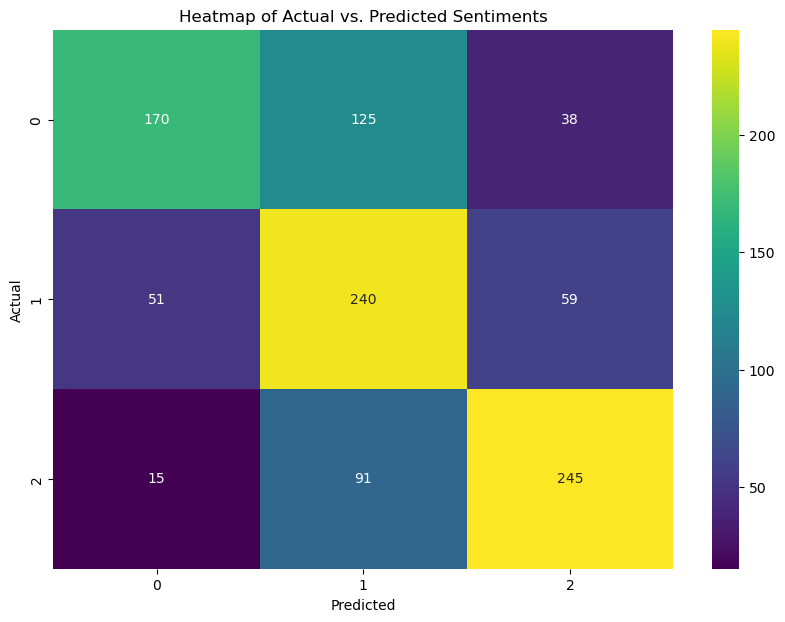

              precision    recall  f1-score   support

    negative       0.72      0.51      0.60       333
     neutral       0.53      0.69      0.60       350
    positive       0.72      0.70      0.71       351

    accuracy                           0.63      1034
   macro avg       0.65      0.63      0.63      1034
weighted avg       0.65      0.63      0.63      1034



In [20]:
merged_df = all_df
accuracy = accuracy_score(merged_df['annotator_combined'], merged_df['sentiment_pred_bert'])
precision = precision_score(merged_df['annotator_combined'], merged_df['sentiment_pred_bert'], average='weighted')
recall = recall_score(merged_df['annotator_combined'], merged_df['sentiment_pred_bert'], average='weighted')
f1 = f1_score(merged_df['annotator_combined'], merged_df['sentiment_pred_bert'], average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate the confusion matrix
cm = confusion_matrix(merged_df['annotator_combined'], merged_df['sentiment_pred_bert'])

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=True, yticklabels=True)
plt.title('Heatmap of Actual vs. Predicted Sentiments')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
print(classification_report(merged_df['annotator_combined'], merged_df['sentiment_pred_bert'], target_names=sentiment_labels.values()))

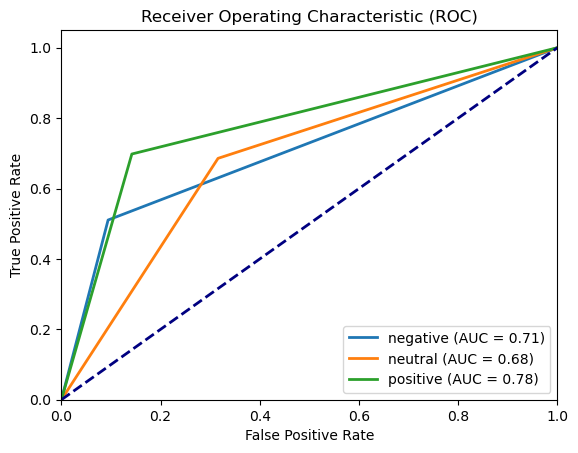

In [21]:

from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

labels = merged_df['annotator_combined']
classes = ['negative', 'neutral', 'positive']
y_true = label_binarize(labels, classes=classes)

# Assuming 'positive' class is considered as the positive class
# Convert sentiment scores to binary predictions
predicted_scores = merged_df['sentiment_pred_bert']
y_score = label_binarize(predicted_scores, classes=classes)
n_classes = len(classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='%s (AUC = %0.2f)' % (class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()